In [15]:
import sys
sys.path.insert(0, "/homes/irene.ferranti/Desktop/CGW_discovery/discovery/src")
import importlib
importlib.reload(importlib.import_module("discovery"))

import os, glob, json
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import inspect
from functools import wraps
import collections.abc
import functools
import scipy as sp
#import discovery.deterministic_time as det_time

#%matplotlib inline
import jax
import jax.numpy as jnp
import jax.random as jr

#import discovery_upd as ds # updated ds
import discovery as ds # my cgw version
import discovery.samplers.numpyro as ds_numpyro
import discovery.deterministic as det
# import discovery.deterministic_time as det_time
from discovery import prior

from discovery import const
from discovery import matrix

import numpyro.distributions as dist
import numpyro.infer as infer
import numpyro

# from flowjax.bijections import RationalQuadraticSpline, Affine
# from flowjax.distributions import StandardNormal, Transformed
# from flowjax.flows import masked_autoregressive_flow, triangular_spline_flow, coupling_flow
# from flowjax.train import fit_to_key_based_loss
# from flowjax.train.losses import ElboLoss
# import discovery.flow as fw
# import equinox as eqx
# import flowjax
# import optax

jax.config.update('jax_enable_x64', True)

import pandas as pd

print(numpyro.__file__)

/homes/irene.ferranti/.local/lib/python3.11/site-packages/numpyro/__init__.py


In [16]:
log10_h0 = -11.5
log10_f0 = -8.3
log10_M0 = 9.2
ra = 1.35
sindec = -0.2
cosinc = 0.2
psi = 1.2
phi_earth = 1.5

cwpars = np.array([cosinc, log10_M0, log10_f0, log10_h0, phi_earth, psi, ra, sindec])

truths = {}
truths['cw_cosinc'] = 0.2
truths['cw_sindec'] = 0.3
truths['cw_psi'] = psi
truths['cw_ra'] = ra
truths['cw_phi_earth'] = phi_earth
truths['cw_log10_h0'] = log10_h0
truths['cw_log10_f0'] = log10_f0
truths['cw_log10_Mc'] = log10_M0

In [17]:
path = '5nHzet_wn_ds_noTM_feathers/'
s_dsfiles = os.listdir(path)
d_psrs = [ds.Pulsar.read_feather(path + f'{psrfile}') for psrfile in s_dsfiles]

In [ ]:
def fpc_fast(pos, gwtheta, gwphi):
    x, y, z = pos

    sin_phi = jnp.sin(gwphi)
    cos_phi = jnp.cos(gwphi)
    sin_theta = jnp.sin(gwtheta)
    cos_theta = jnp.cos(gwtheta)

    m_dot_pos = sin_phi * x - cos_phi * y
    n_dot_pos = -cos_theta * cos_phi * x - cos_theta * sin_phi * y + sin_theta * z
    omhat_dot_pos = -sin_theta * cos_phi * x - sin_theta * sin_phi * y - cos_theta * z

    denom = 1.0 + omhat_dot_pos

    fplus = 0.5 * (m_dot_pos**2 - n_dot_pos**2) / denom
    fcross = (m_dot_pos * n_dot_pos) / denom

    return fplus, fcross, omhat_dot_pos

def makedelay_binary_evolution_nopsrterm(evolve = True):
    if evolve:
        print("Including frequency evolution")
        @jax.jit(static_argnums=(0,1))
        def delay_binary(toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc):
            """BBH residuals from Ellis et. al 2012, 2013"""

            h0 = 10**log10_h0
            f0 = 10**log10_f0

            dec, inc = jnp.arcsin(sindec), jnp.arccos(cosinc)

            # calculate antenna pattern (note: pos is pulsar sky position unit vector)
            fplus, fcross = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)  # careful with dec -> gwtheta conversion
            phi_avg = phi_earth

            tref = 0.
            Mc = 10**log10_Mc * const.Tsun # convert to time
            f = f0 * (1 - 256/5 * Mc**(5/3) * ((jnp.pi*f0)**(8/3) *(toas - tref)))**(-3/8) # Here I'm using only pi * f_gw !!!
            phase = phi_avg + 2 * (1/32) * (1/Mc**(5/3)) * ((jnp.pi * f0)**(-5/3) - (jnp.pi * f)**(-5/3))
            
            cphase, sphase = jnp.cos(phase), jnp.sin(phase)

            # fix this for no pulsarterm

            delta_sin = sphase
            delta_cos = cphase

            At = -1.0 * (1.0 + jnp.cos(inc)**2) * delta_sin
            Bt =  2.0 * jnp.cos(inc) * delta_cos

            alpha = h0 / (2 * jnp.pi * f0)

            # calculate rplus and rcross
            rplus  = alpha * (-At * jnp.cos(2 * psi) + Bt * jnp.sin(2 * psi))
            rcross = alpha * ( At * jnp.sin(2 * psi) + Bt * jnp.cos(2 * psi))

            # calculate residuals
            res = -fplus * rplus - fcross * rcross

            return res
    else:
        print("No frequency evolution")
        @jax.jit(static_argnums=(0,1))
        def delay_binary(toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc):

            """BBH residuals from Ellis et. al 2012, 2013"""

            h0 = 10**log10_h0
            f0 = 10**log10_f0

            dec, inc = jnp.arcsin(sindec), jnp.arccos(cosinc)

            # calculate antenna pattern (note: pos is pulsar sky position unit vector)
            fplus, fcross, cosMu = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)  # careful with dec -> gwtheta conversion

            phi_avg = phi_earth

            tref = 0.
            phase = phi_avg + 2.0 * jnp.pi * f0 * (toas - tref)
            
            cphase, sphase = jnp.cos(phase), jnp.sin(phase)

            # fix this for no pulsarterm

            delta_sin = sphase
            delta_cos = cphase

            At = -1.0 * (1.0 + jnp.cos(inc)**2) * delta_sin
            Bt =  2.0 * jnp.cos(inc) * delta_cos

            alpha = h0 / (2 * jnp.pi * f0)

            # calculate rplus and rcross
            rplus  = alpha * (-At * jnp.cos(2 * psi) + Bt * jnp.sin(2 * psi))
            rcross = alpha * ( At * jnp.sin(2 * psi) + Bt * jnp.cos(2 * psi))

            # calculate residuals
            res = -fplus * rplus - fcross * rcross

            return res

    return delay_binary    

In [19]:
def makedelay_binary_sincos(evolve=False):
    delay_binary = makedelay_binary_evolution_nopsrterm(evolve=False)

    def delay_binary_sincos(toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc):
             return delay_binary(toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc)

    return delay_binary_sincos

cgw_delay = makedelay_binary_sincos()
cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra', 'cw_log10_Mc']


In [20]:
def makemodel_curn_cgw_EPTA_simulation(psrs):

    pslmodels = []
    tspan = ds.getspan(psrs)

    for p in psrs:
        
        model = [p.residuals,
                 ds.makenoise_measurement(p, p.noisedict, tnequad=True),
                 # ds.makegp_timing(p, svd=True, variance=1e-40),
                 ds.makedelay(p, cgw_delay, name='cw', common=cwcommon)]

        # print(p.noisedict[p.name + '_dm_gp_components'])
        if p.noisedict[p.name + '_dm_gp_components']:
            model.append(ds.makegp_fourier(p, ds.powerlaw, p.noisedict[p.name + '_dm_gp_components'], T=ds.getspan(p), name='dm_gp', fourierbasis=ds.make_dmfourierbasis(alpha = 2.0, tndm = True)))

        # print(p.noisedict[p.name + '_red_components'])
        if p.noisedict[p.name + '_red_components']:
            model.append(ds.makegp_fourier(p, ds.powerlaw, p.noisedict[p.name + '_red_components'], T=tspan, name='red_noise'))

        pslmodels.append(ds.PulsarLikelihood(model))

    return ds.GlobalLikelihood(pslmodels)

In [21]:
sim_model = makemodel_curn_cgw_EPTA_simulation(d_psrs)
_, residuals = sim_model.sample(jax.random.key(345), truths)

In [22]:
for ii, psr in enumerate(d_psrs):
    psr.residuals = np.array(residuals[ii]).squeeze()

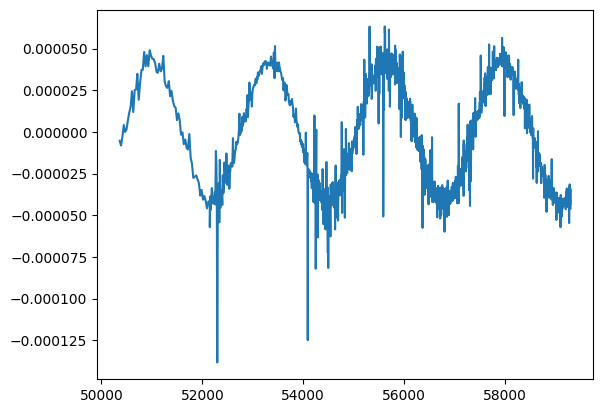

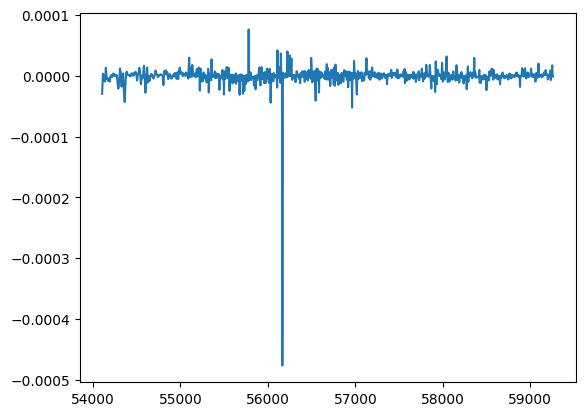

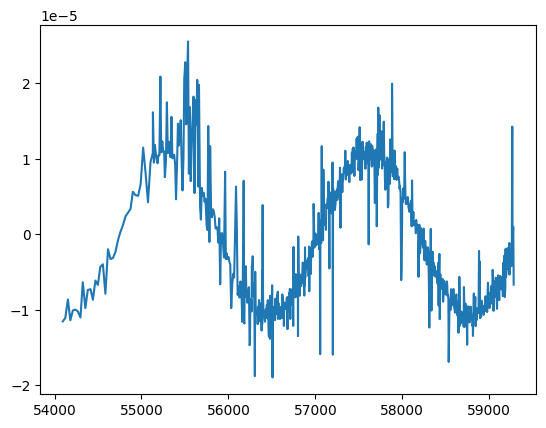

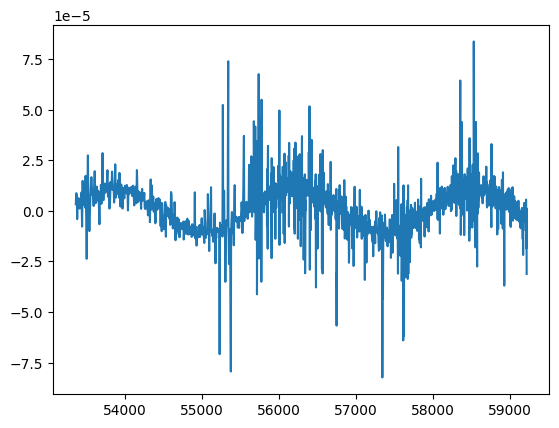

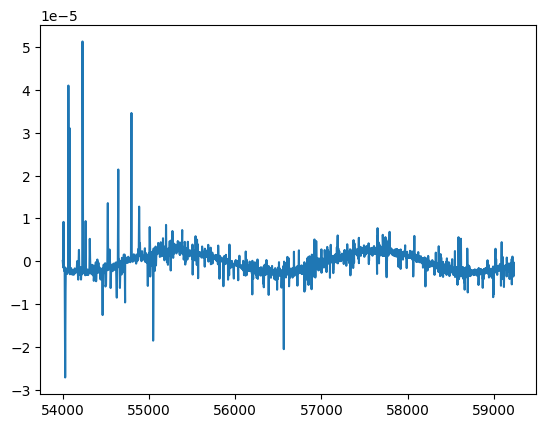

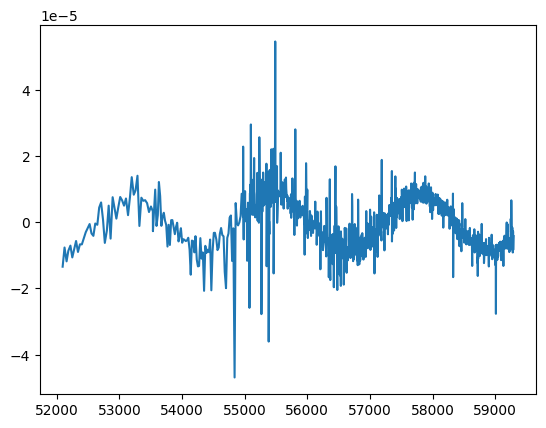

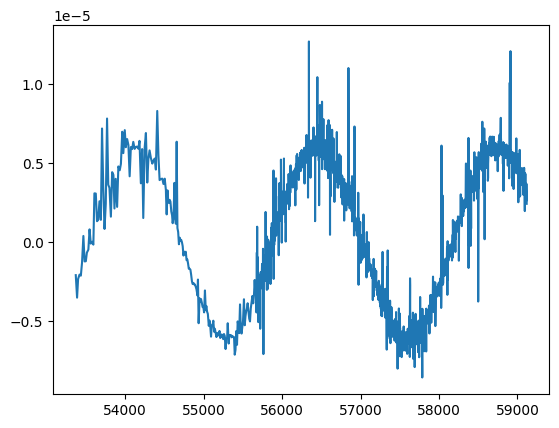

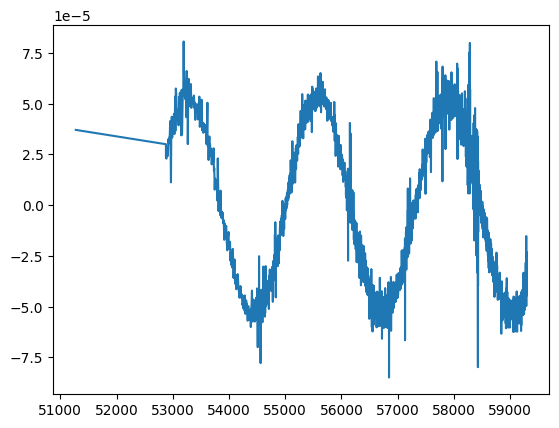

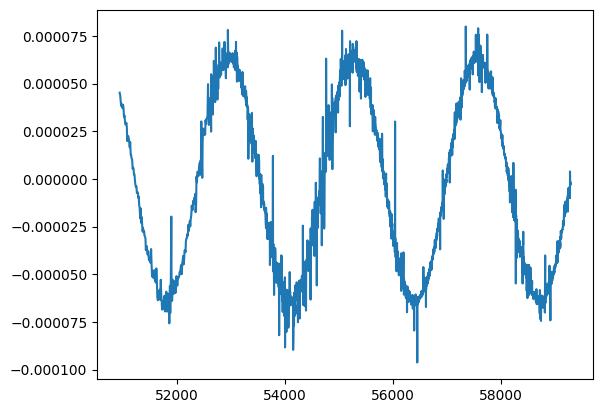

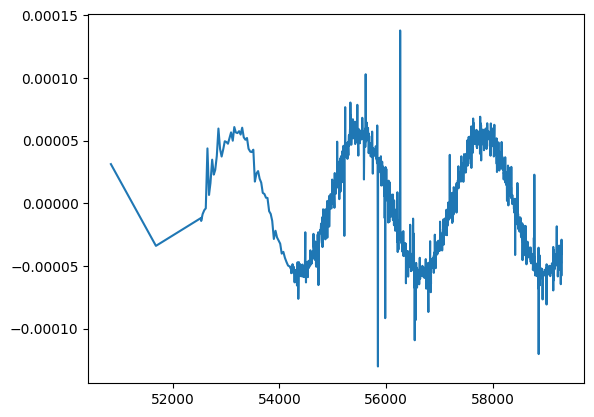

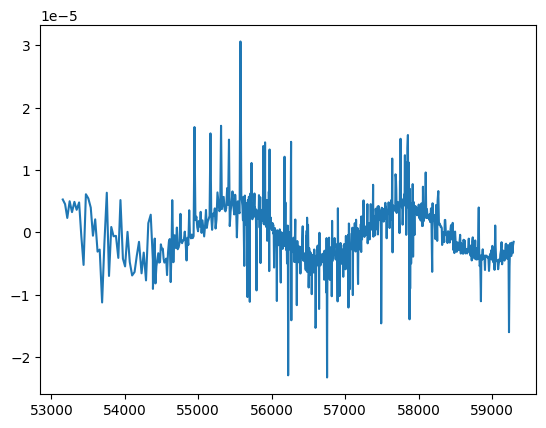

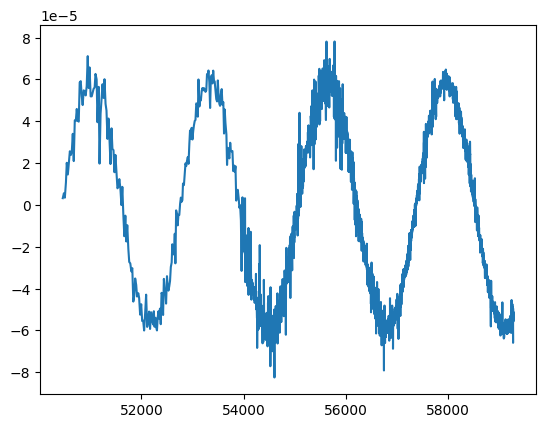

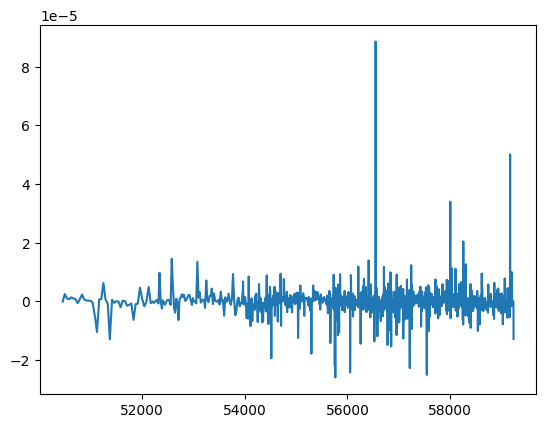

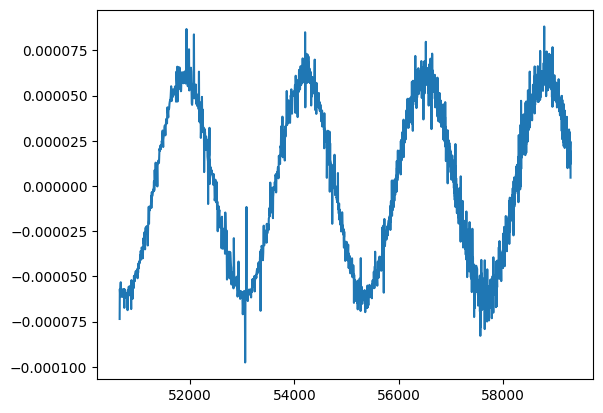

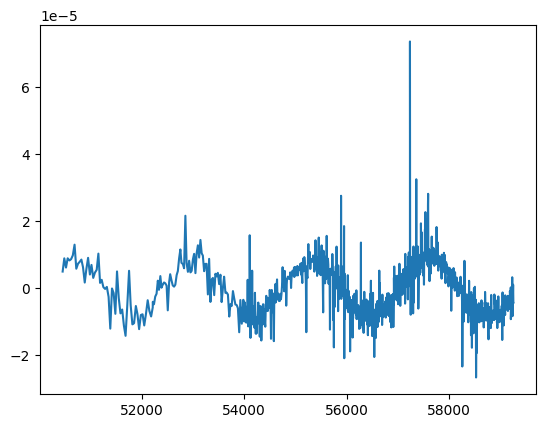

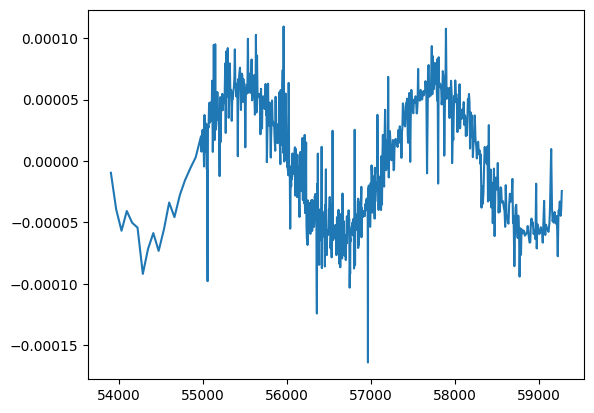

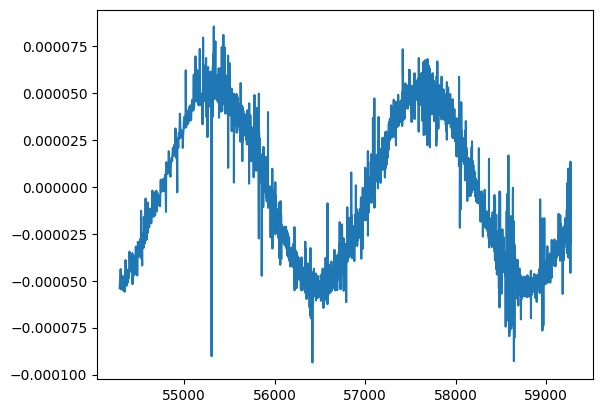

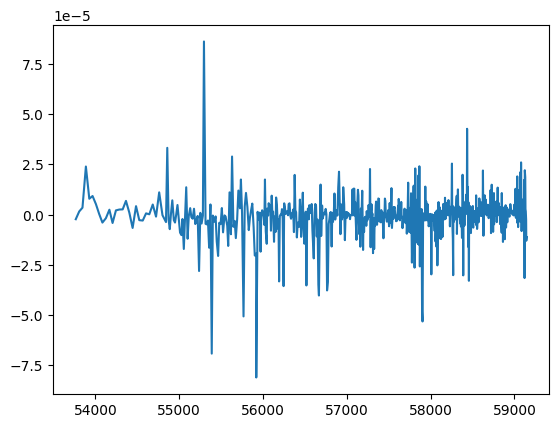

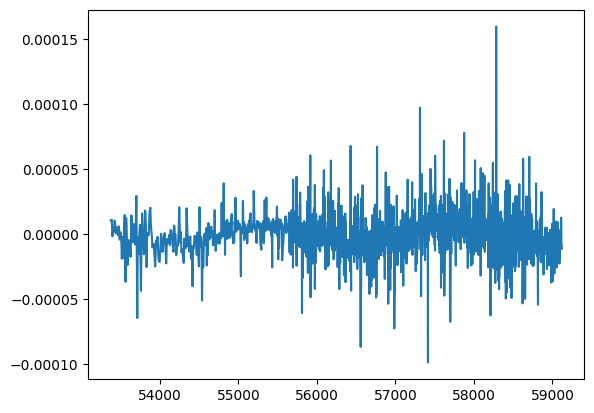

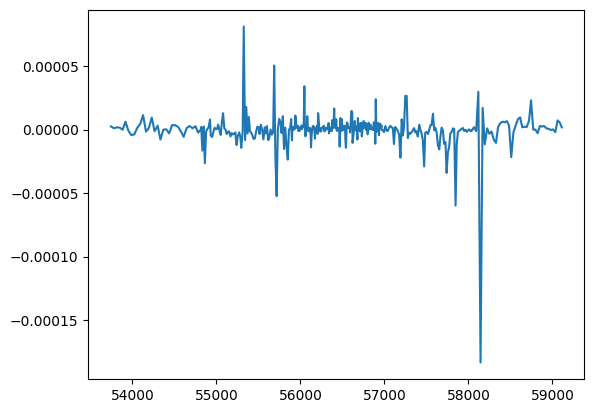

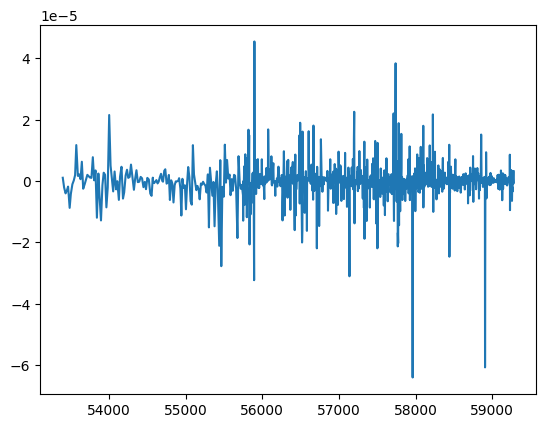

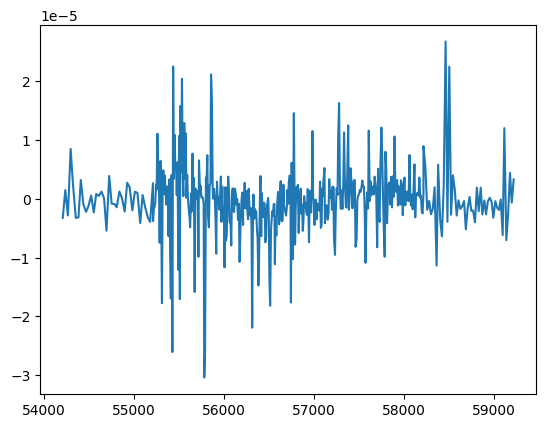

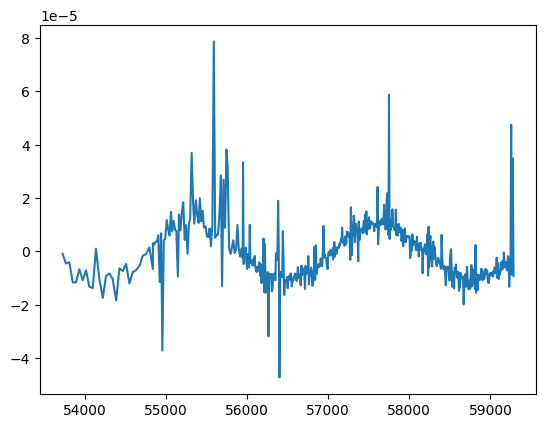

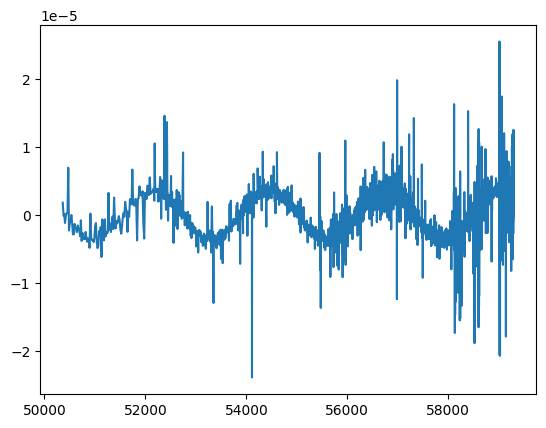

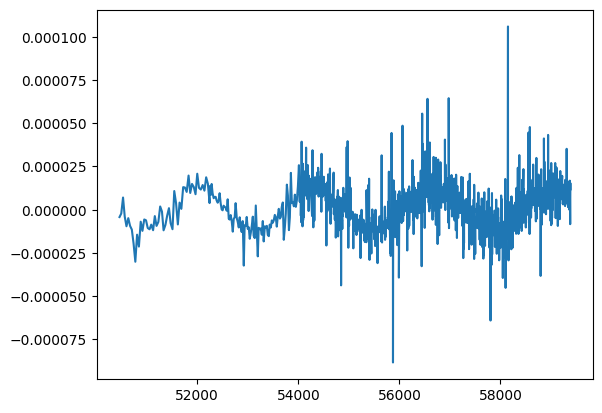

In [23]:
for psr in d_psrs:
    plt.figure()
    plt.plot(psr.toas/3600/24, psr.residuals)
    plt.show()

In [25]:
import os
dirpath = '5nHzet_wn_ds_noTM_feathers/'
if not os.path.exists(dirpath):
        os.makedirs(dirpath)

for psr in d_psrs:
    ds.pulsar.Pulsar.save_feather(psr, dirpath + psr.name, noisedict=psr.noisedict)